Parametrisierung einer Geraden über ihren Normalenwinkel $\varphi$ und ihren Abstand $r$ zum Ursprung.

## 0. Pfade, Pakete etc.

In [19]:
import glob

%matplotlib inline
import matplotlib.pyplot as plt

import imageio
import numpy as np
import math
import scipy.ndimage

In [20]:
image_path = 'faces/e-6.jpg'

## 1. Laden des Bildes

In [21]:
original_image = imageio.imread(image_path)
grayscale = lambda img: np.mean(img, axis=2)
image = grayscale(original_image)

/tmp/ipykernel_12207/2344831437.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_image = imageio.imread(image_path)


Für diese Aufgabe ist es wichtig, das Bild im Fließkommaformat vorliegen zu haben. Konvertieren sie `image` zu einer geeigneten Repräsentation:

In [22]:
image = np.asarray(image, dtype=np.float32) / 255

Schauen wir uns erstmal das Bild an:

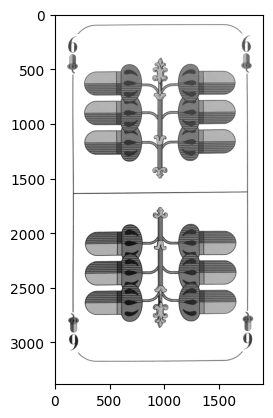

In [23]:
plt.imshow(image, cmap='gray', vmin=0, vmax=1)
plt.show()

## 2. Kantenbild berechnen
Die Hough-Transformation muss auf Kantenbilder angewendet werden. Nutzen Sie daher einen geeigneten Kantenfilter (z. B. Sobel), um die Gradienten in horizontaler und vertikaler Richtung zu ermitteln und daraus die Kantenstärke zu berechnen. Zur Durchführung der Faltung können Sie die Funktion `scipy.ndimage.convolve` verwenden.

In [24]:
filter_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])
filter_y = filter_x.T

edges_x = scipy.ndimage.convolve(image, filter_x)
edges_y = scipy.ndimage.convolve(image, filter_y)

edge_image = np.sqrt(edges_x ** 2 + edges_y ** 2)

Visualisieren Sie nun das Kantenbild:

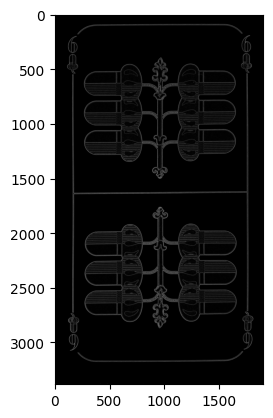

In [25]:
plt.figure()
plt.imshow(edge_image, cmap='gray')
plt.show()

## 3. Hough-Transformation
Zunächst soll eine Funktion `ex5_hough_transform` definiert werden, die die Hough-Transformation durchführt und den Akkumulator sowie dessen Grenzwerte zurückliefert.

Als Eingabe erhält die Funktion das zuvor berechnete Kantenstärkenbild sowie die Anzahl der Diskretisierungsschritte für Radius und Winkel, welche die Größe und Auflösung des Hough-Arrays bestimmen.

In [26]:
THRESHOLD = 0.1
MIN_RATIO = 2

def accumulate(edge_image, edges_x, edges_y):
    # vertical (horizontal) line: see where horizontal (vertical) change is above a threshold and where horizontal (vertical) change is much larger than the vertical (horizontal) change
    worthy_vertical = (edges_x > THRESHOLD) & (edges_y / np.maximum(edges_x, THRESHOLD) < 1 / MIN_RATIO)
    worthy_horizontal = (edges_y > THRESHOLD) & (edges_x / np.maximum(edges_y, THRESHOLD) < 1 / MIN_RATIO)
    # then accumulate the horizontal (vertical) change along the vertical (horizontal) axis where points could be a vertical (horizontal) line
    accu_vertical = np.sum(edge_image, where=worthy_vertical, axis=0)
    accu_horizontal = np.sum(edge_image, where=worthy_horizontal, axis=1)
    return accu_vertical, accu_horizontal

Nun berechnen wir den Hough-Akkumulator und dessen Grenzwerte.

In [27]:
# detect 2 vertical and 2 horizontal lines
vertical_accumulator, horizontal_accumulator = accumulate(edge_image, edges_x, edges_y)

In [28]:
def detect_lines_simple(acc, n):
    return np.argsort(acc)[-n:]

In [29]:
vertical_lines = detect_lines_simple(vertical_accumulator, 10)
horizontal_lines = detect_lines_simple(horizontal_accumulator, 15)

Stellen Sie nun die detektierten Geraden graphisch dar, indem Sie diese in das Bild einzeichnen.

In [30]:
def plot_vertical(x, image_shape):
    plt.plot([x, x], [0, image_shape[0] - 1], color='red')
    
def plot_horizontal(y, image_shape):
    plt.plot([0, image_shape[1] - 1], [y, y], color='red')

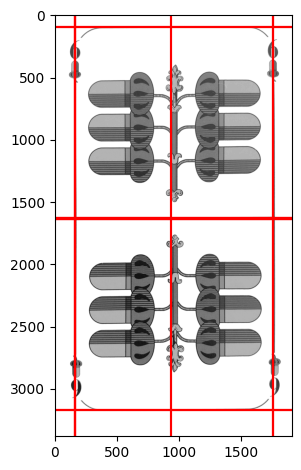

In [31]:
plt.figure()
plt.imshow(image, cmap='gray')
for x in vertical_lines:
    plot_vertical(x, image.shape)
for y in horizontal_lines:
    plot_horizontal(y, image.shape)
plt.ylim(image.shape[0] - 1, 0)
plt.xlim(0, image.shape[1] - 1)
plt.tight_layout()
plt.show()

## 5. Glättung und Non-Maximum-Suppression

Erweitern Sie nun die oben definierte Funktion `ex5_detect_lines` in einer neuen Funktion `ex5_detect_lines_ex`, welche zusätzlich eine Glättung des übergebenen Hough-Akkumulators mithilfe eines Gaußfilters vornimmt und die Detektion doppelter Linien vermeidet, indem Ausschläge in einer bestimmten Nachbarschaft um das gefundene Maximum herum unterdrückt werden.

In [32]:
ACCU_FILTER_SIZE = 3
ACCU_NMP_RADIUS = 100

sigma = ACCU_FILTER_SIZE / 5
filter_offs = ACCU_FILTER_SIZE // 2
X = np.arange(-filter_offs, filter_offs + 1)
GAUSS_FILTER = np.exp(-X**2 / (2 * sigma * sigma))


def detect_lines(acc, n):
    # Gaussian smoothing
    acc = scipy.ndimage.convolve(acc, GAUSS_FILTER, mode='constant', cval=0)

    # Detect lines with non-maximum suppression
    lines = []
    while (len(lines) < n) and np.any(acc):
        # Find point with highest scores
        i = np.argmax(acc)
        lines.append(i)
        # Eliminate non-maxima in the local neighborhood
        acc[max(0, i - ACCU_NMP_RADIUS):i + ACCU_NMP_RADIUS] = 0

    return lines


In [33]:
vertical_lines = detect_lines(vertical_accumulator, 3)
horizontal_lines = detect_lines(horizontal_accumulator, 5)

Nun werden die detektierten Linien visualisiert:

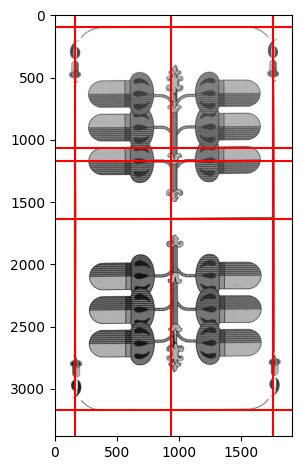

In [34]:
plt.figure()
plt.imshow(image, cmap='gray')
for x in vertical_lines:
    plot_vertical(x, image.shape)
for y in horizontal_lines:
    plot_horizontal(y, image.shape)
plt.ylim(image.shape[0] - 1, 0)
plt.xlim(0, image.shape[1] - 1)
plt.tight_layout()
plt.show()

## 6. Find Center of the card

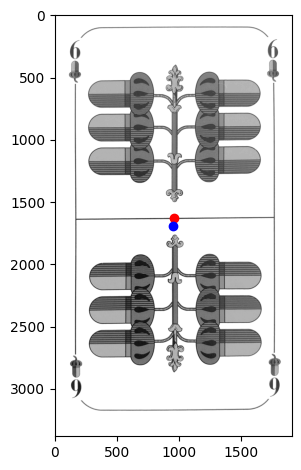

In [35]:
x_center = np.mean([np.min(vertical_lines), np.max(vertical_lines)])
y_center = np.mean([np.min(horizontal_lines), np.max(horizontal_lines)])
x_center_wanted = image.shape[1] // 2
y_center_wanted = image.shape[0] // 2

plt.figure()
plt.imshow(image, cmap='gray')
plt.plot(x_center, y_center, 'ro')
plt.plot(x_center_wanted, y_center_wanted, 'bo')
plt.ylim(image.shape[0] - 1, 0)
plt.xlim(0, image.shape[1] - 1)
plt.tight_layout()
plt.show()

-3 60


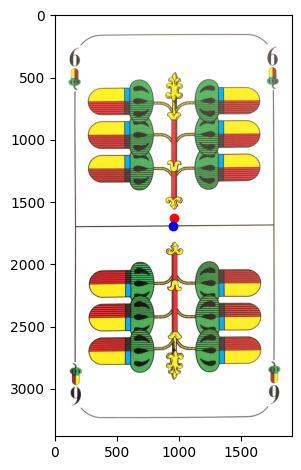

In [36]:
from PIL import Image, ImageOps, ImageChops
x_offset = round(x_center_wanted - x_center)
y_offset = round(y_center_wanted - y_center)
print(x_offset, y_offset)
pil_image = Image.fromarray(original_image)
pil_image = ImageChops.offset(pil_image, x_offset, y_offset)
image = np.array(pil_image)
plt.figure()
plt.imshow(image, cmap='gray')
plt.plot(x_center, y_center, 'ro')
plt.plot(x_center_wanted, y_center_wanted, 'bo')
plt.ylim(image.shape[0] - 1, 0)
plt.xlim(0, image.shape[1] - 1)
plt.tight_layout()
plt.show()